# Análise de Vibração em Cadeias de Átomos com Defeito de Massa

## Parâmetros do Problema

- **Massas padrão:** `m = 1 kg`  
- **Constante elástica:** `k = 1 N/m`  
- **Tamanhos da cadeia:** `N = 100`, `1000`, `10.000`  
- **Defeito:** massa central `m2 = 5 kg` (apenas em uma das simulações)  

As extremidades da cadeia estão livres.

## 1. Cálculo das Frequências de Vibração

Para cada valor de `N`, calcule as frequências naturais de vibração do sistema em duas situações:

- **Cadeia homogênea:** todas as massas iguais a `m`.
- **Cadeia com defeito de massa:** massa central substituída por `m2 = 5m`.

Os autovalores da matriz dinâmica representam os quadrados das frequências naturais.

## 2. Densidade de Estados

Construa histogramas das frequências naturais (√autovalores) para:

- Cadeias homogêneas e com defeito
- Diferentes tamanhos de `N`

Compare os histogramas para analisar o efeito do defeito e do tamanho da cadeia sobre a distribuição espectral.


## 3. Deslocamentos Relativos (Modos Normais)

Para cada cadeia:

- Obtenha os autovetores associados às cinco menores e cinco maiores frequências.
- Plote os vetores de deslocamento dos átomos para esses modos.

Estes modos revelam padrões coletivos e localizados de oscilação.


## 4. Análise e Comparação

Analise como o **tamanho da cadeia** e a **presença do defeito de massa** afetam:

- A **distribuição das frequências naturais** (densidade de estados)
- Os **modos normais de vibração**

### Pontos de discussão:
- Como os modos de alta e baixa frequência se comportam?
- O defeito de massa introduz modos localizados?
- Há deslocamentos significativos próximos ao defeito?

## Orientações para Implementação em Python

- Comente e documente o código de forma clara.
- Utilize as bibliotecas `numpy` e `matplotlib`.
- Calcule autovalores e autovetores da matriz dinâmica.
- Para valores grandes de `N`, implemente otimizações:
  - Use `scipy.sparse` e `eigsh` para matrizes esparsas.
- Publique o código final em um repositório no GitHub.
- Inclua o link do repositório no relatório final.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import time
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

In [68]:
# Parâmetros físicos
m = 1.0             # massa padrão (kg)
m2 = 5.0            # massa do defeito (kg) 
k = 1.0             # constante das molas (N/m)
len_cadeias = [100, 1000, 10000]  # número de átomos na cadeia

In [69]:
# Função principal da simulação

class CadeiaAtom1D:
    def __init__(self, m: float = 1.0, m2: float = 5.0, k: float = 1.0):
        self.m = m
        self.m2 = m2
        self.k = k
        self.results = {}
    
    def construct_dynamical_matrix(self, N: int, defect: bool = False):
        masses = np.full(N, self.m)
        if defect and N > 1:
            center_idx = N // 2
            masses[center_idx] = self.m2
        
        if N > 500:
            return self._construct_sparse_matrix(N, masses)
        else:
            return self._construct_dense_matrix(N, masses)
    
    def _construct_dense_matrix(self, N: int, masses: np.ndarray) -> np.ndarray:
        D = np.zeros((N, N))
        
        for i in range(N):
            if i > 0:
                D[i, i] += self.k / masses[i]
            if i < N-1:
                D[i, i] += self.k / masses[i]
            
            if i > 0:
                D[i, i-1] = -self.k / np.sqrt(masses[i] * masses[i-1])
            if i < N-1:
                D[i, i+1] = -self.k / np.sqrt(masses[i] * masses[i+1])
        
        return D
    
    def _construct_sparse_matrix(self, N: int, masses: np.ndarray) -> csc_matrix:
        diag_vals = np.zeros(N)
        for i in range(N):
            if i > 0:
                diag_vals[i] += self.k / masses[i]
            if i < N-1:
                diag_vals[i] += self.k / masses[i]
        
        off_diag_upper = np.zeros(N-1)
        off_diag_lower = np.zeros(N-1)
        
        for i in range(N-1):
            coupling = -self.k / np.sqrt(masses[i] * masses[i+1])
            off_diag_upper[i] = coupling
            off_diag_lower[i] = coupling
        
        diagonals = [off_diag_lower, diag_vals, off_diag_upper]
        offsets = [-1, 0, 1]
        
        return diags(diagonals, offsets, shape=(N, N), format='csc')
    
    def compute_eigenfrequencies(self, N: int, defect: bool = False) -> Tuple[np.ndarray, np.ndarray]:
        print(f"Calculando autofrequências para N={N}, defeito={defect}")
        start_time = time.time()
        
        D = self.construct_dynamical_matrix(N, defect)

        if N > 500:
            k_eigs = min(N-1, 200)
            eigenvals, eigenvecs = eigsh(D, k=k_eigs, which='SM', 
                                       return_eigenvectors=True)
            if eigenvals.shape[0] < N:
                print(f"  Calculados {eigenvals.shape[0]} autovalores de {N}")
        else:
            eigenvals, eigenvecs = eigh(D)
        
        eigenvals = np.maximum(eigenvals, 0)
        
        frequencies = np.sqrt(eigenvals)
        
        sort_idx = np.argsort(frequencies)
        frequencies = frequencies[sort_idx]
        eigenvecs = eigenvecs[:, sort_idx]
        
        computation_time = time.time() - start_time
        print(f"  Concluído em {computation_time:.2f} segundos")
        
        return frequencies, eigenvecs
    
    def run_simulation(self, len_cadeias: List[int]) -> Dict:
        results = {}
        
        for N in len_cadeias:
            print(f"\n--- Simulando cadeia com N={N} átomos ---")
            results[N] = {}
            
            # Cadeia homogênea
            freq_homo, modes_homo = self.compute_eigenfrequencies(N, defect=False)
            results[N]['homogeneous'] = {
                'frequencies': freq_homo,
                'modes': modes_homo
            }
            
            # Cadeia heterogênea
            freq_defect, modes_defect = self.compute_eigenfrequencies(N, defect=True)
            results[N]['defective'] = {
                'frequencies': freq_defect,
                'modes': modes_defect
            }
        
        self.results = results
        return results

In [70]:
# Iniciando a simulação
print("Iniciando a simulação...")
chain = CadeiaAtom1D(m=m, m2=m2, k=k)

print("Executando a simulação para todos os tamanhos de cadeia...")
results = chain.run_simulation(len_cadeias)

print("\n=== Simulação concluída com sucesso! ===")

Iniciando a simulação...
Executando a simulação para todos os tamanhos de cadeia...

--- Simulando cadeia com N=100 átomos ---
Calculando autofrequências para N=100, defeito=False
  Concluído em 0.01 segundos
Calculando autofrequências para N=100, defeito=True
  Concluído em 0.01 segundos

--- Simulando cadeia com N=1000 átomos ---
Calculando autofrequências para N=1000, defeito=False
  Calculados 200 autovalores de 1000
  Concluído em 0.49 segundos
Calculando autofrequências para N=1000, defeito=True
  Calculados 200 autovalores de 1000
  Concluído em 0.45 segundos

--- Simulando cadeia com N=10000 átomos ---
Calculando autofrequências para N=10000, defeito=False
  Calculados 200 autovalores de 10000
  Concluído em 18.89 segundos
Calculando autofrequências para N=10000, defeito=True
  Calculados 200 autovalores de 10000
  Concluído em 20.16 segundos

=== Simulação concluída com sucesso! ===


In [71]:
def plot_density_of_states(
    results: Dict, 
    len_cadeias: List[int], 
    bins: int = 50, 
    figsize: Tuple[int, int] = (15, 10)
):
    n_chains = len(len_cadeias)
    fig, axes = plt.subplots(2, n_chains, figsize=figsize, squeeze=False)
    
    for i, N in enumerate(len_cadeias):
        if N not in results:
            continue
        
        data_for_N = results[N]
        freq_homo = data_for_N['homogeneous']['frequencies']
        freq_defect = data_for_N['defective']['frequencies']

        freq_min = min(freq_homo.min(), freq_defect.min())
        freq_max = max(freq_homo.max(), freq_defect.max())
        bin_edges = np.linspace(freq_min, freq_max, bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        plot_configs = [
            {'data': freq_homo,   'ax': axes[0, i], 'color': 'blue', 'label': 'Homogênea'},
            {'data': freq_defect, 'ax': axes[1, i], 'color': 'red',  'label': 'Heterogênea'}
        ]
        
        all_counts = []
        for config in plot_configs:
            ax = config['ax']
            counts, _, _ = ax.hist(
                config['data'], 
                bins=bin_edges, 
                density=True, 
                alpha=0.9,
                color=config['color'], 
                histtype='step',
                linewidth=2
            )
            all_counts.append(counts)
            
            ax.set_title(f'Cadeia {config["label"]} (N={N})', fontsize=14, fontweight='bold')
            ax.set_xlabel('Frequência ($rad/s$)')
            ax.set_ylabel('Densidade de Estados')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=10)

        if any(c.size > 0 for c in all_counts):
            y_max = max(c.max() for c in all_counts if c.size > 0) * 1.1
            axes[0, i].set_ylim(0, y_max)
            axes[1, i].set_ylim(0, y_max)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Comparação da Densidade de Estados Vibracionais', 
                 fontsize=16, fontweight='bold')
    plt.show()

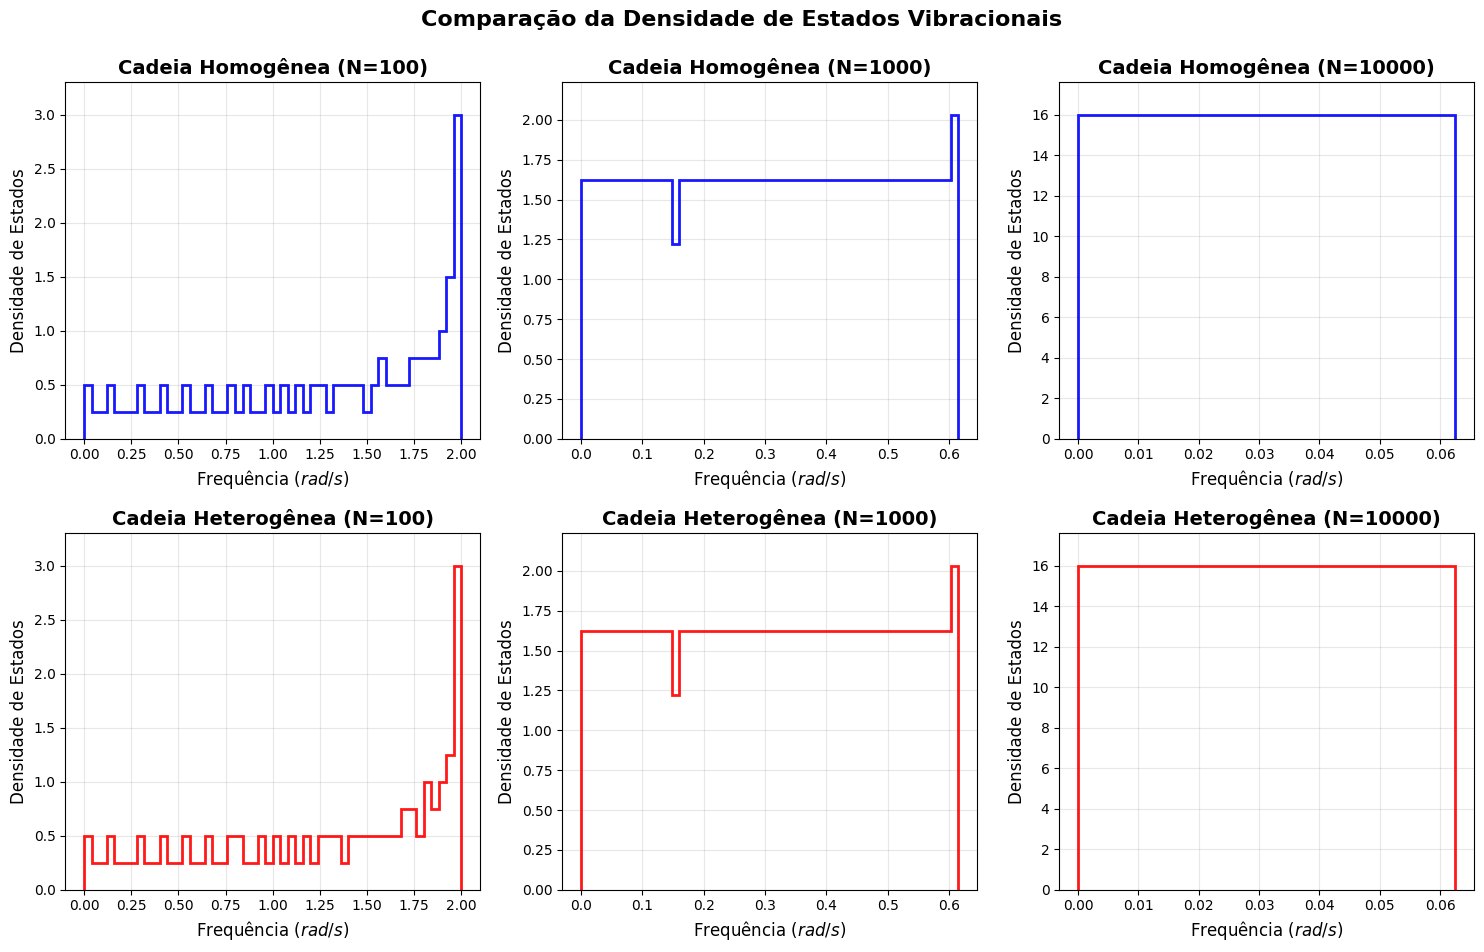

In [72]:
plot_density_of_states(results, len_cadeias)

In [73]:
def plot_normal_modes(
    results: Dict, 
    N: int, 
    n_modes: int = 5,
    defect_mass: Optional[float] = None,
    figsize: Tuple[int, int] = (30, 15)
):
    if N not in results:
        print(f"Sem resultados para N={N}. Dados da simulação não encontrados.")
        return

    def _plot_single_mode(ax, data, title):
        ax.plot(data['positions'], data['shape'], 'o-', color=data['color'], 
                linewidth=1, markersize=2, alpha=0.8)
        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Posição do Átomo', fontsize=8)
        ax.set_ylabel('Amplitude de Deslocamento', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        y_max = np.abs(data['shape']).max() * 1.15
        ax.set_ylim(-y_max, y_max)
        
        if data['config_name'] == 'defective':
            defect_pos = N // 2
            if defect_mass is not None:
                label += f' (m={defect_mass})'
            ax.axvline(x=defect_pos, color='magenta', linestyle='--', 
                       alpha=0.7, linewidth=2)
            ax.legend(fontsize=9, loc='upper right')

    fig, axes = plt.subplots(4, n_modes, figsize=figsize, squeeze=False)
    
    for config_idx, config_name in enumerate(['homogeneous', 'defective']):
        config_data = results[N][config_name]
        frequencies = config_data['frequencies']
        modes = config_data['modes']
        total_modes = len(frequencies)
        
        for type_idx, mode_type in enumerate(['Menores', 'Maiores']):
            for i in range(min(n_modes, total_modes)):
                
                if mode_type == 'Menores':
                    mode_idx = i
                else:
                    mode_idx = total_modes - n_modes + i
                
                if mode_idx < 0 or mode_idx >= total_modes:
                    continue

                ax = axes[config_idx * 2 + type_idx, i]
                mode_shape = modes[:, mode_idx]
                
                plot_data = {
                    'positions': np.arange(N),
                    'shape': mode_shape,
                    'color': 'blue' if config_name == 'homogeneous' else 'red',
                    'config_name': config_name
                }
                
                title = (
                    f'{config_name.capitalize()} - {mode_type} Modos #{i+1}\n'
                    f'$\\omega = {frequencies[mode_idx]:.4f}$ rad/s'
                )
                
                _plot_single_mode(ax, plot_data, title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f'Formas dos Modos Normais para N={N}', fontsize=16, fontweight='bold')
    plt.show()

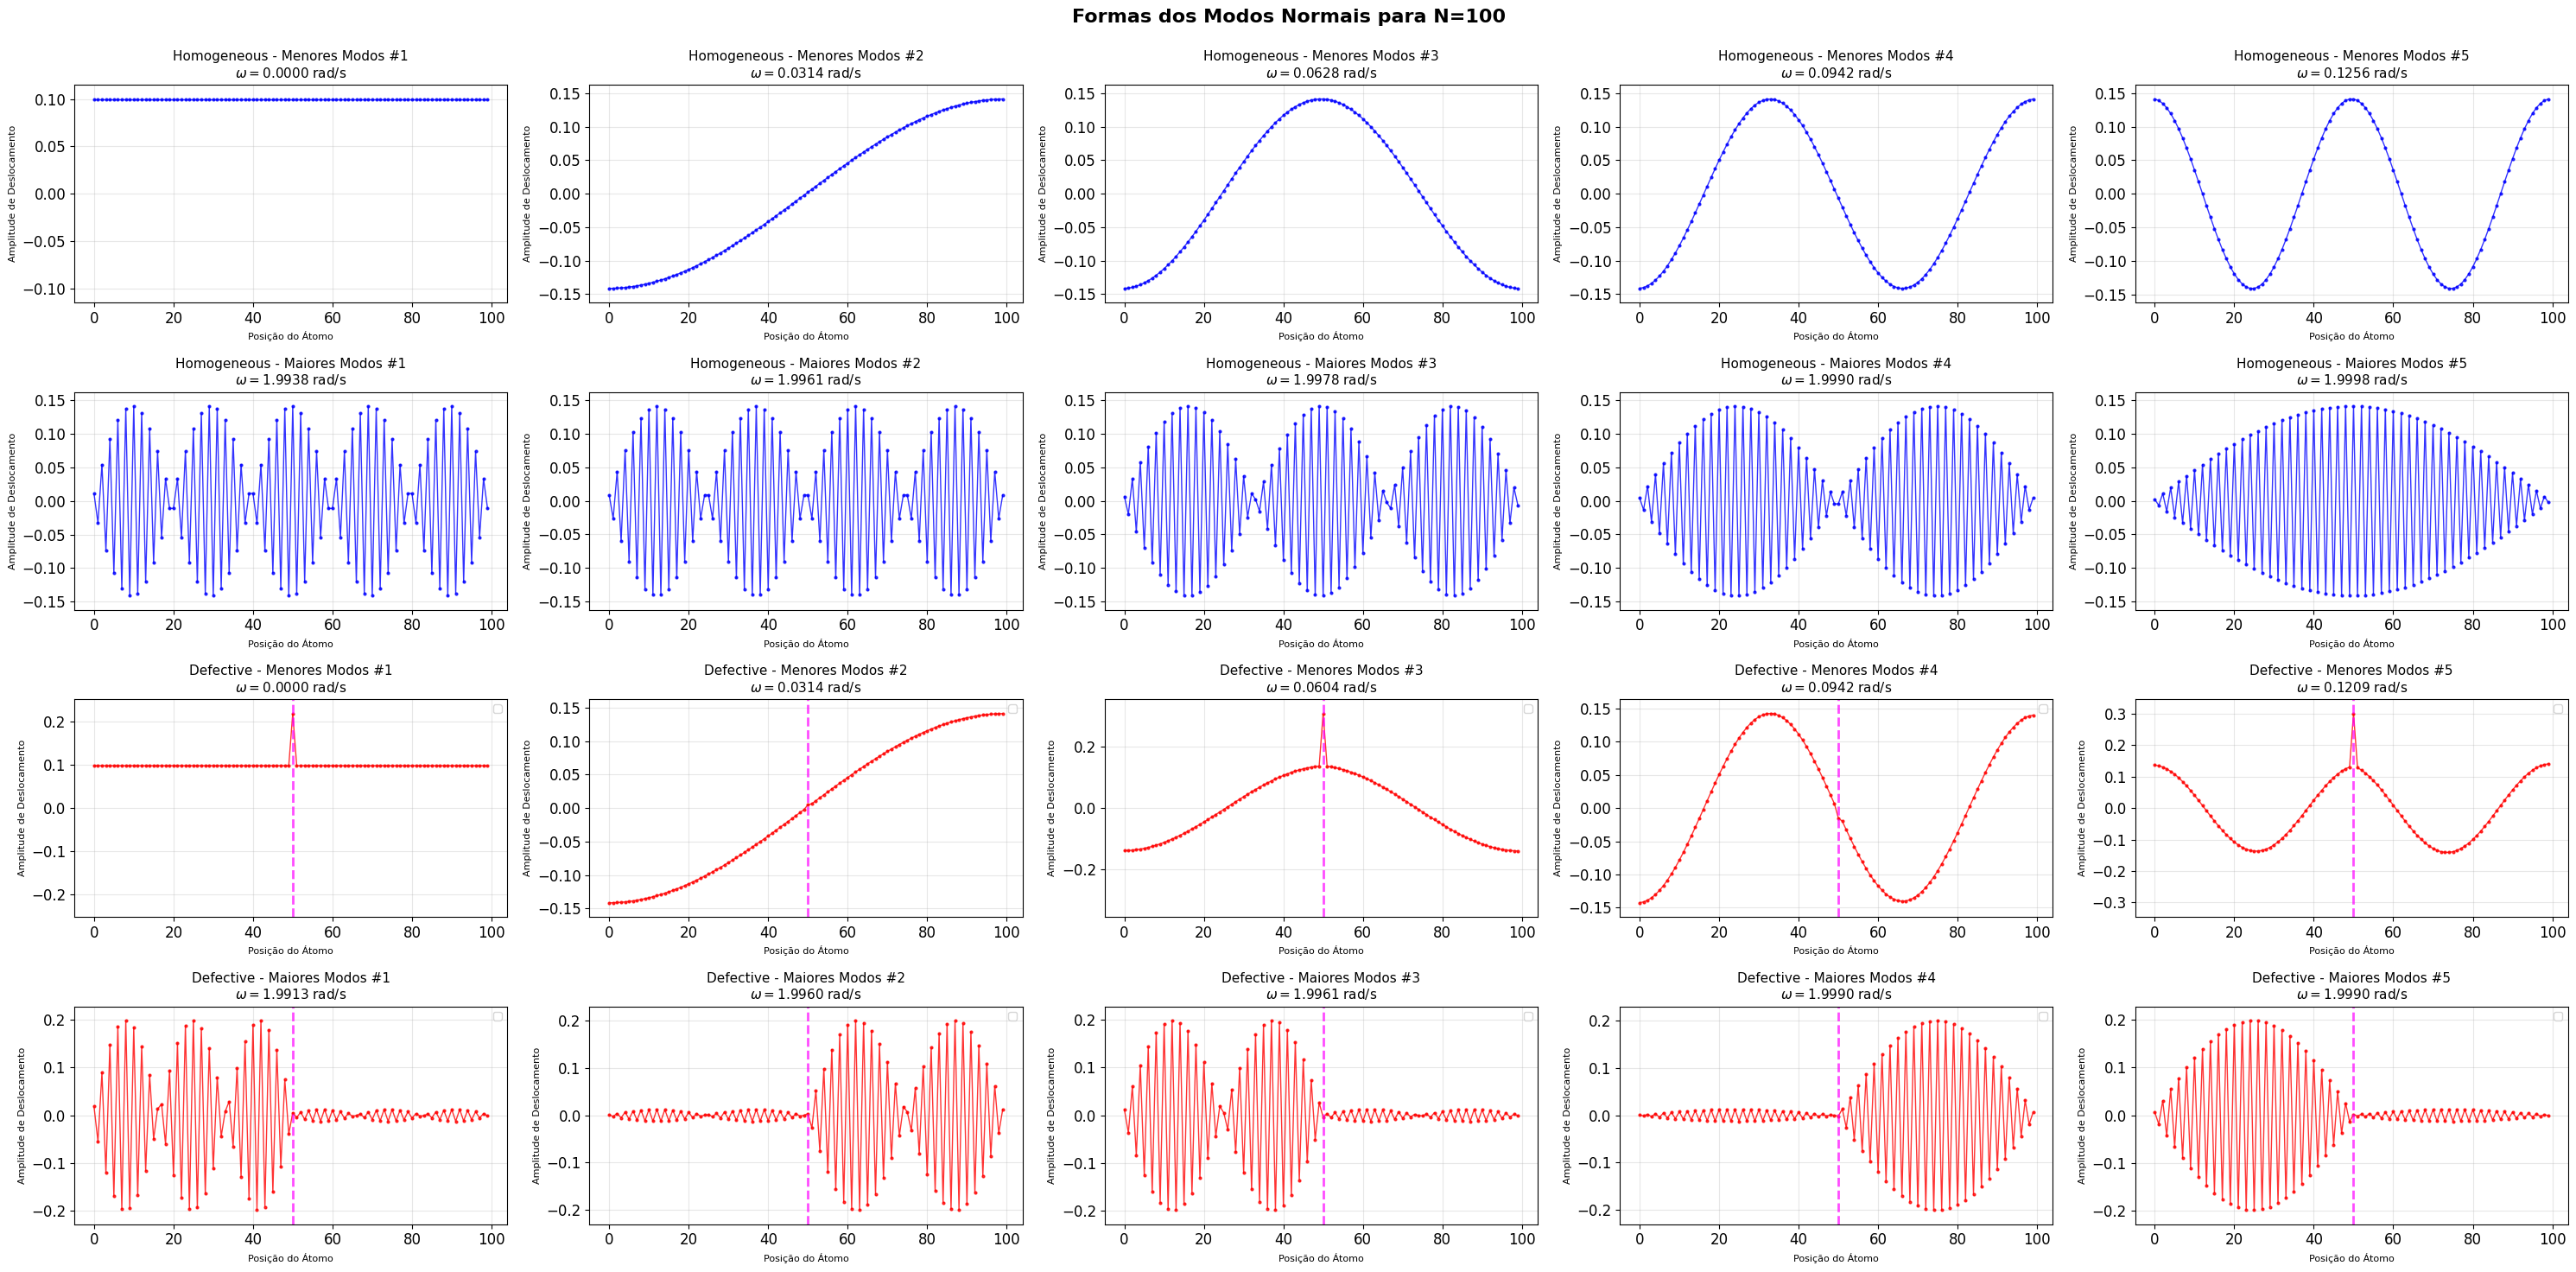

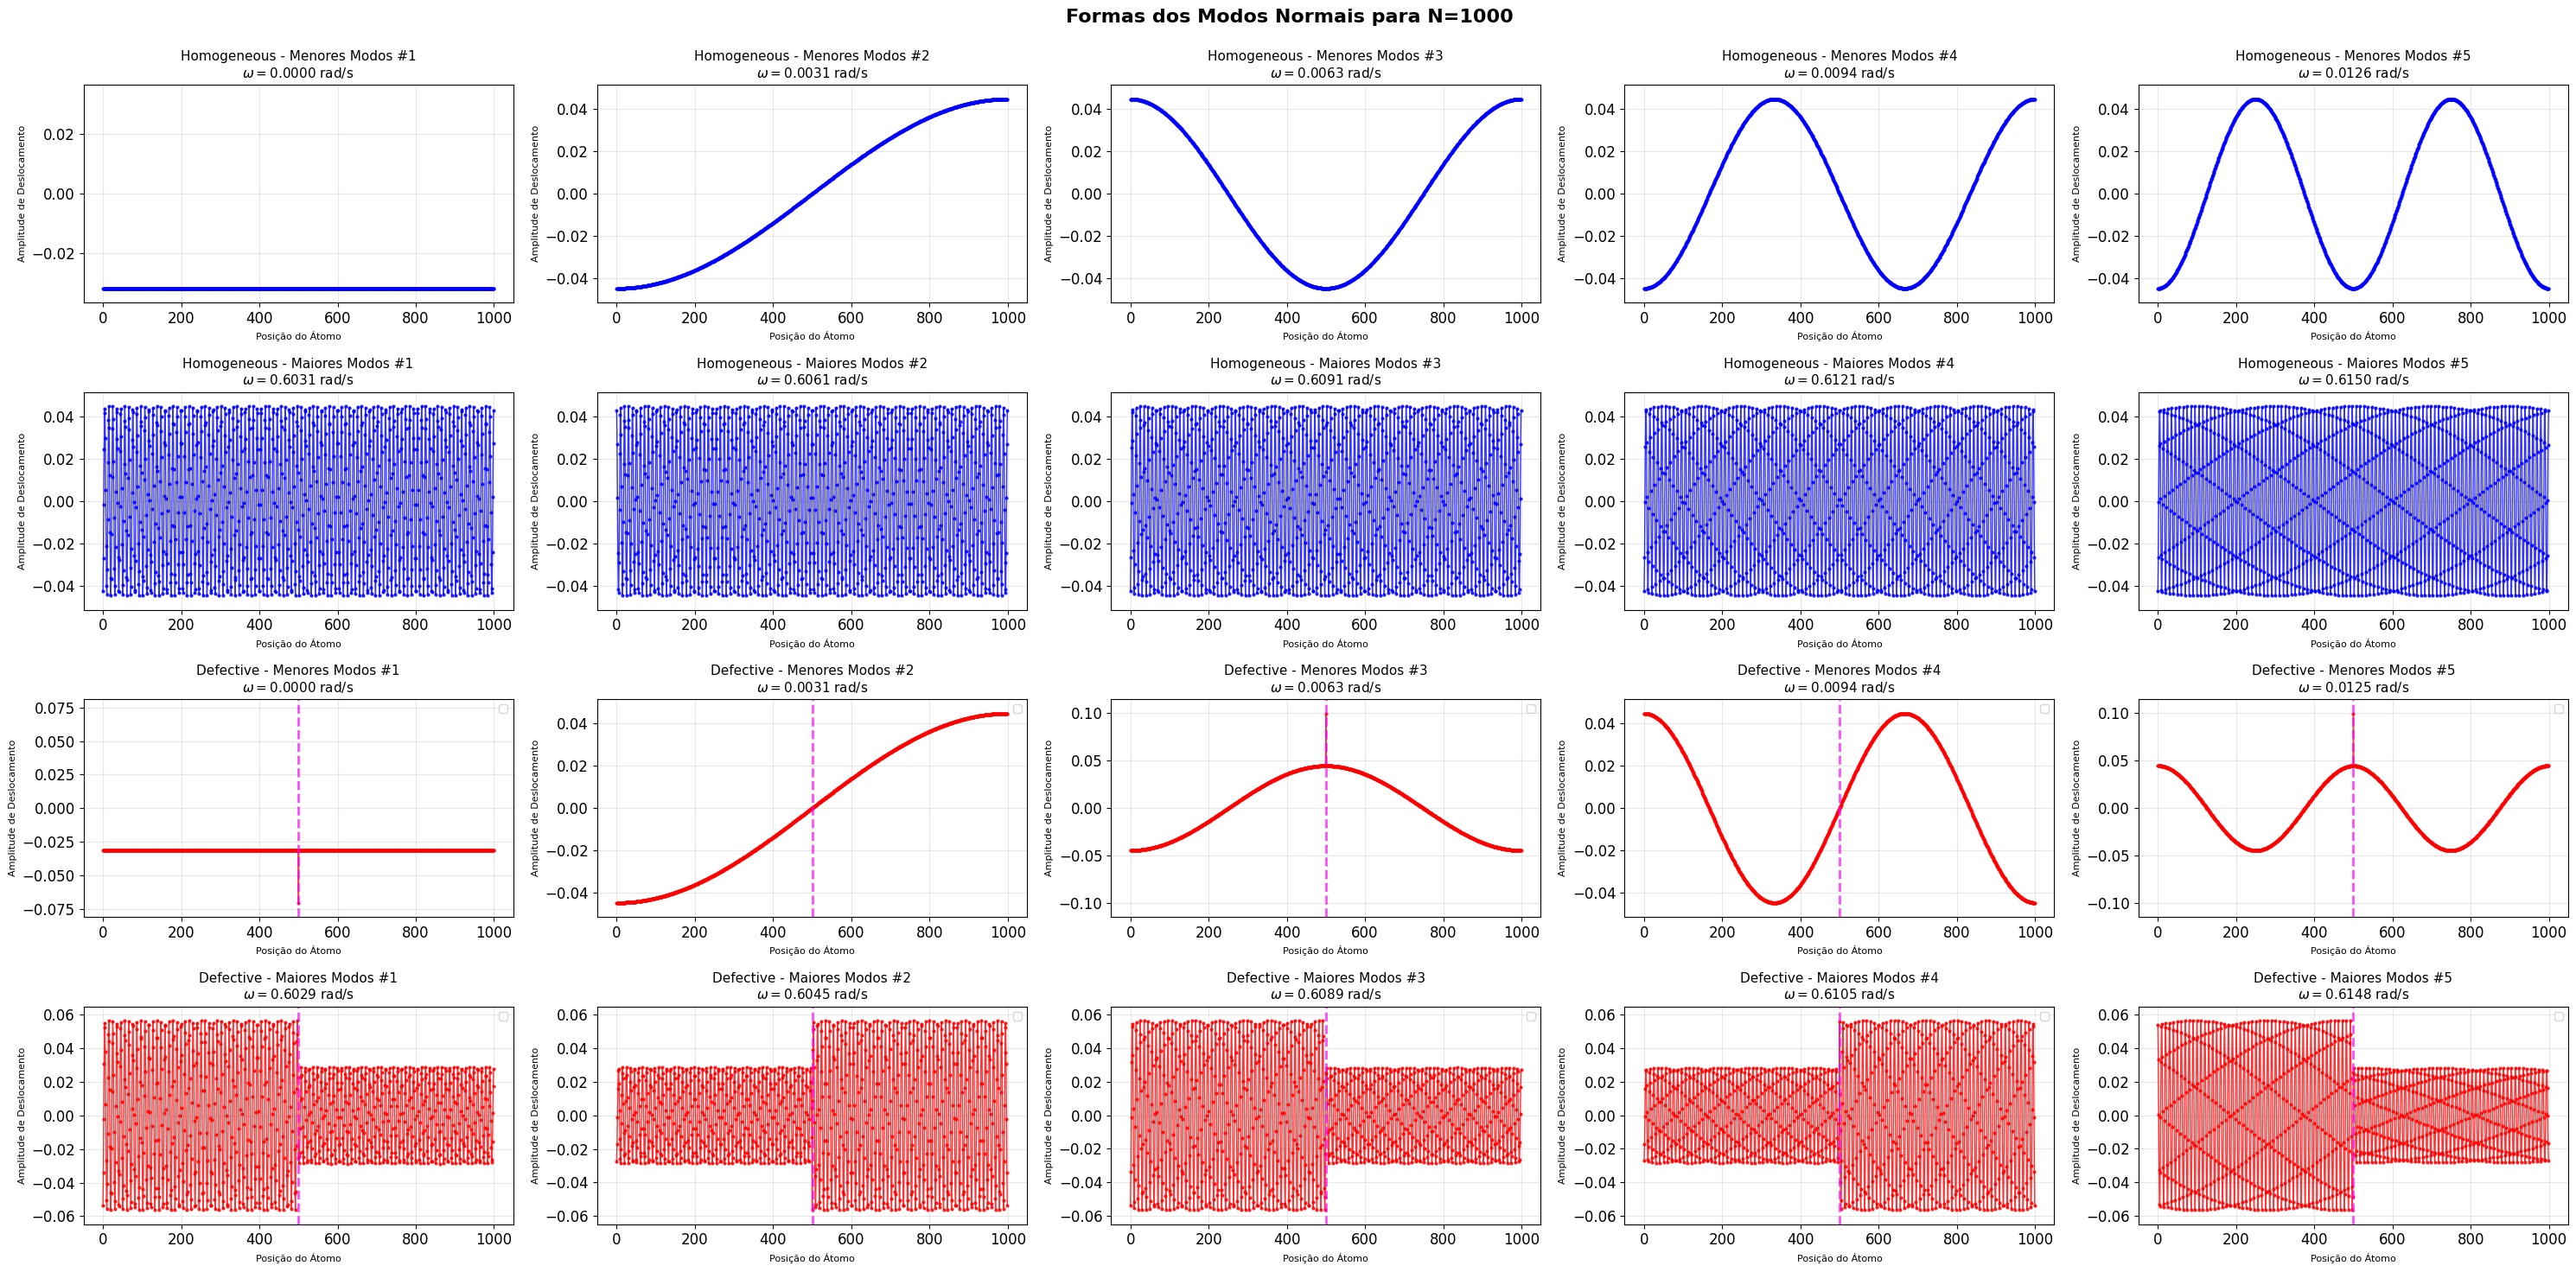

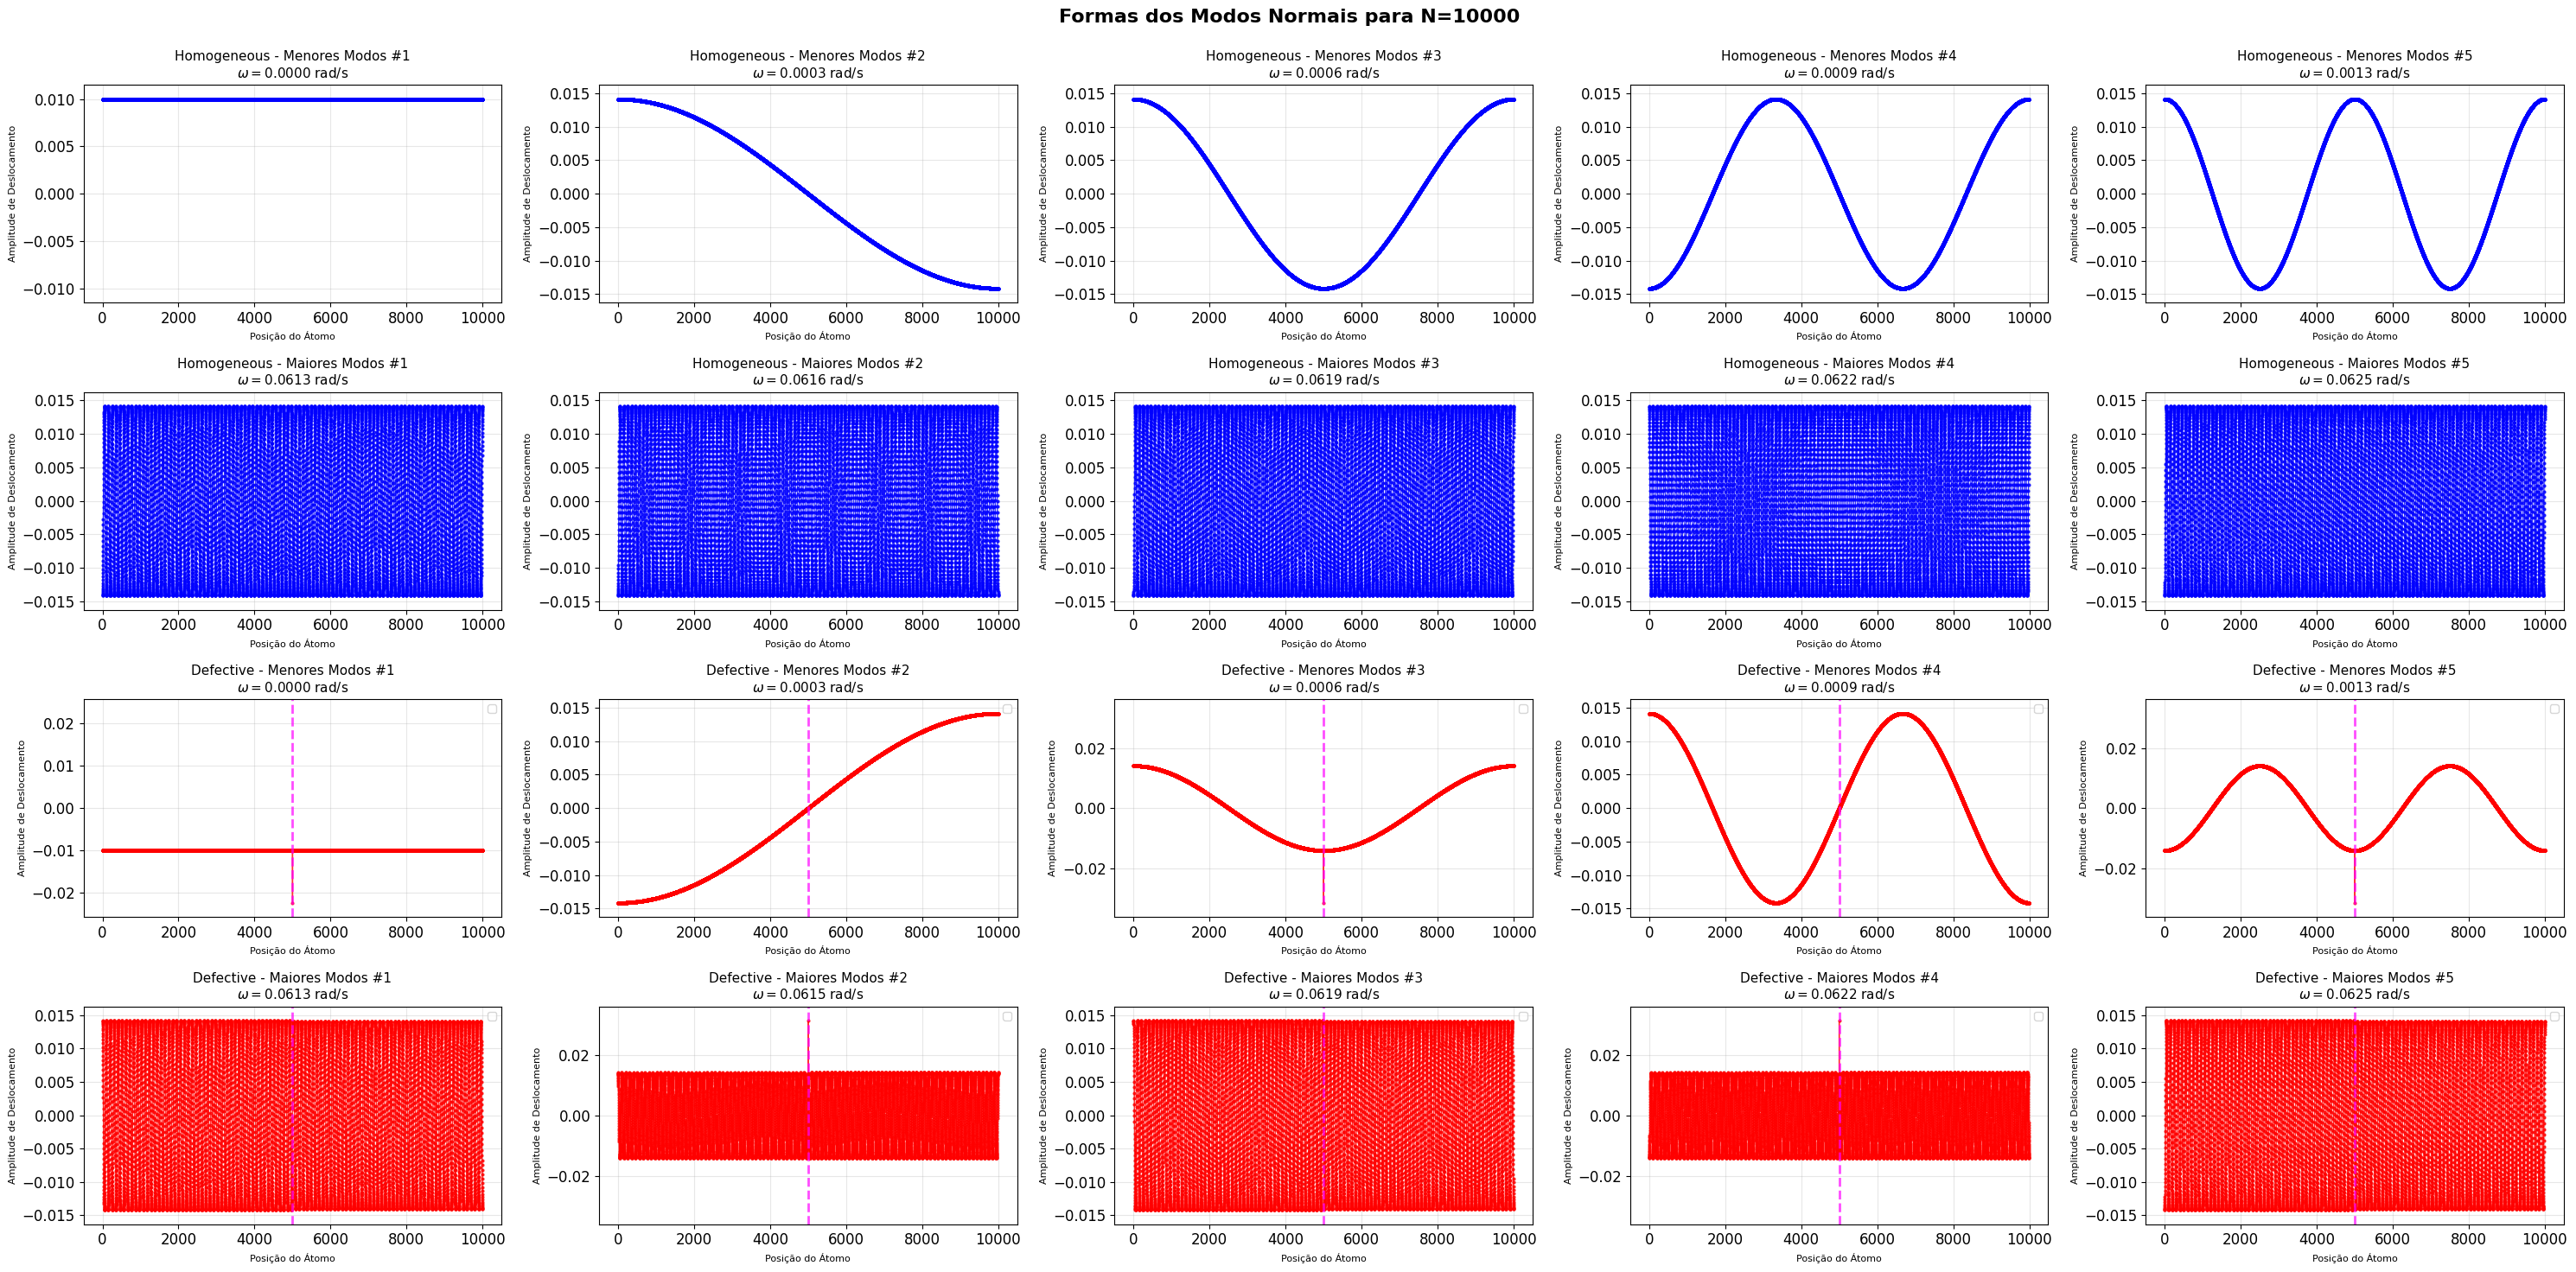

In [74]:
for N in len_cadeias:
        plot_normal_modes(results, N)

In [75]:
def analyze_defect_effects(results: Dict, N: int):
    if N not in results:
        print(f"Sem resultados para N={N}. Dados da simulação não encontrados.")
        return
    
    homo_freq = results[N]['homogeneous']['frequencies']
    defect_freq = results[N]['defective']['frequencies']
    defect_modes = results[N]['defective']['modes']
    
    print(f"\n{'='*50}")
    print(f"ANÁLISE DO DEFEITO PARA N={N}")
    print(f"{'='*50}")
    
    print(f"\nEstatísticas de Frequência:")
    print(f"  Cadeia Homogênea:")
    print(f"    Intervalo: {homo_freq.min():.4f} - {homo_freq.max():.4f} rad/s")
    print(f"    Média: {homo_freq.mean():.4f} rad/s")
    print(f"    Std: {homo_freq.std():.4f} rad/s")
    print(f"    Número de modos: {len(homo_freq)}")
    
    print(f"\n  Cadeia Heterogênea:")
    print(f"    Intervalo: {defect_freq.min():.4f} - {defect_freq.max():.4f} rad/s")
    print(f"    Média: {defect_freq.mean():.4f} rad/s")
    print(f"    Std: {defect_freq.std():.4f} rad/s")
    print(f"    Número de modos: {len(defect_freq)}")
    
    freq_shift_max = defect_freq.max() - homo_freq.max()
    freq_shift_min = defect_freq.min() - homo_freq.min()
    
    print(f"\n  Deslocamento da Frequência:")
    print(f"    Deslocamento Máximo: {freq_shift_max:.4f} rad/s")
    print(f"    Deslocamento Mínimo: {freq_shift_min:.4f} rad/s")

    if len(defect_freq) > 0 and N > 1:
        center_idx = N // 2

        localization = np.abs(defect_modes[center_idx, :]) ** 2

        localized_threshold = 0.1
        localized_modes = np.where(localization > localized_threshold)[0]
        
        print(f"\n  Análise da Localização Espacial:")
        print(f"    Posição do defeito: átomo {center_idx}")
        print(f"    Limite de localização: {localized_threshold:.1%}")
        print(f"    Número de modos localizados: {len(localized_modes)}")
        
        if len(localized_modes) > 0:
            print(f"\n    Principais modos localizados:")

            sorted_indices = localized_modes[np.argsort(localization[localized_modes])[::-1]]
            
            for i, mode_idx in enumerate(sorted_indices[:5]):  # Show top 5
                freq = defect_freq[mode_idx]
                loc_strength = localization[mode_idx]
                print(f"      Modo {mode_idx:3d}: f={freq:7.4f} rad/s, "
                      f"localização={loc_strength:.3f} ({loc_strength:.1%})")
        else:
            print(f"    Não foram encontrados modos fortemente localizados (limite: {localized_threshold:.1%})")
    
    # Gap analysis
    print(f"\n  Análise de gap de frequência:")
    homo_gaps = np.diff(homo_freq)
    defect_gaps = np.diff(defect_freq)
    
    if len(homo_gaps) > 0 and len(defect_gaps) > 0:
        print(f"    Cadeia Homogênea - maior gap: {homo_gaps.max():.4f} rad/s")
        print(f"    Cadeia Heterogênea - maior gap: {defect_gaps.max():.4f} rad/s")
        
        # Look for significant gaps (> 2 standard deviations)
        homo_gap_threshold = homo_gaps.mean() + 2 * homo_gaps.std()
        defect_gap_threshold = defect_gaps.mean() + 2 * defect_gaps.std()
        
        homo_large_gaps = np.where(homo_gaps > homo_gap_threshold)[0]
        defect_large_gaps = np.where(defect_gaps > defect_gap_threshold)[0]
        
        print(f"    Gaps significativos na cadeia homogênea: {len(homo_large_gaps)}")
        print(f"    Gaps significativos na cadeia heterogênea: {len(defect_large_gaps)}")

In [76]:
for N in len_cadeias:
    analyze_defect_effects(results, N)


ANÁLISE DO DEFEITO PARA N=100

Estatísticas de Frequência:
  Cadeia Homogênea:
    Intervalo: 0.0000 - 1.9998 rad/s
    Média: 1.2632 rad/s
    Std: 0.6199 rad/s
    Número de modos: 100

  Cadeia Heterogênea:
    Intervalo: 0.0000 - 1.9990 rad/s
    Média: 1.2566 rad/s
    Std: 0.6204 rad/s
    Número de modos: 100

  Deslocamento da Frequência:
    Deslocamento Máximo: -0.0007 rad/s
    Deslocamento Mínimo: 0.0000 rad/s

  Análise da Localização Espacial:
    Posição do defeito: átomo 50
    Limite de localização: 10.0%
    Número de modos localizados: 0
    Não foram encontrados modos fortemente localizados (limite: 10.0%)

  Análise de gap de frequência:
    Cadeia Homogênea - maior gap: 0.0314 rad/s
    Cadeia Heterogênea - maior gap: 0.0431 rad/s
    Gaps significativos na cadeia homogênea: 0
    Gaps significativos na cadeia heterogênea: 0

ANÁLISE DO DEFEITO PARA N=1000

Estatísticas de Frequência:
  Cadeia Homogênea:
    Intervalo: 0.0000 - 0.6150 rad/s
    Média: 0.3100 rad/

In [77]:
def calculate_participation_ratio(modes: np.ndarray) -> np.ndarray:
    N = modes.shape[0]
    pr = np.zeros(modes.shape[1])
    
    for i in range(modes.shape[1]):
        mode = modes[:, i]
        amplitude_squared = mode**2
        sum_squared = np.sum(amplitude_squared)
        sum_fourth = np.sum(amplitude_squared**2)
        
        if sum_fourth > 0:
            pr[i] = sum_squared**2 / (N * sum_fourth)
        else:
            pr[i] = 0
    
    return pr

def plot_participation_ratio(results: Dict, N: int, figsize: Tuple[int, int] = (12, 8)):
    if N not in results:
        print(f"No results for N={N}.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    homo_freq = results[N]['homogeneous']['frequencies']
    homo_modes = results[N]['homogeneous']['modes']
    homo_pr = calculate_participation_ratio(homo_modes)
    
    ax1.scatter(homo_freq, homo_pr, alpha=0.6, s=20, color='blue')
    ax1.set_xlabel('Frequência (rad/s)')
    ax1.set_ylabel('Razão de Participação')
    ax1.set_title(f'Cadeia Homogênea (N={N})')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    defect_freq = results[N]['defective']['frequencies']
    defect_modes = results[N]['defective']['modes']
    defect_pr = calculate_participation_ratio(defect_modes)
    
    ax2.scatter(defect_freq, defect_pr, alpha=0.6, s=20, color='red')
    ax2.set_xlabel('Frequência (rad/s)')
    ax2.set_ylabel('Razão de Participação')
    ax2.set_title(f'Cadeia Heterogênea (N={N})')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    ax1.axhline(y=1/N, color='black', linestyle='--', alpha=0.5, label=f'Localizado (1/N={1/N:.3f})')
    ax1.axhline(y=1.0, color='black', linestyle='-', alpha=0.5, label='Deslocado (1.0)')
    ax1.legend()
    
    ax2.axhline(y=1/N, color='black', linestyle='--', alpha=0.5, label=f'Localizado (1/N={1/N:.3f})')
    ax2.axhline(y=1.0, color='black', linestyle='-', alpha=0.5, label='Deslocado (1.0)')
    ax2.legend()
    
    plt.tight_layout()
    plt.suptitle(f'Análise da Razão de Participação (N={N})', y=1.02, fontsize=14, fontweight='bold')
    plt.show()

    print(f"\nEstatísticas da razão de participação para N={N}:")
    print(f"  Cadeia Homogênea:")
    print(f"    PR Médio: {homo_pr.mean():.4f}")
    print(f"    PR Std: {homo_pr.std():.4f}")
    print(f"    PR Min: {homo_pr.min():.4f}")
    
    print(f"  Cadeia Heterogênea:")
    print(f"    PR Médio: {defect_pr.mean():.4f}")
    print(f"    PR Std: {defect_pr.std():.4f}")
    print(f"    PR Min: {defect_pr.min():.4f}")
    
    homo_localized = np.sum(homo_pr < 0.5)
    defect_localized = np.sum(defect_pr < 0.5)
    
    print(f"  Modos Localizados (PR < 0.5):")
    print(f"    Homogêneo: {homo_localized} ({homo_localized/len(homo_pr)*100:.1f}%)")
    print(f"    Heterogêneo: {defect_localized} ({defect_localized/len(defect_pr)*100:.1f}%)")

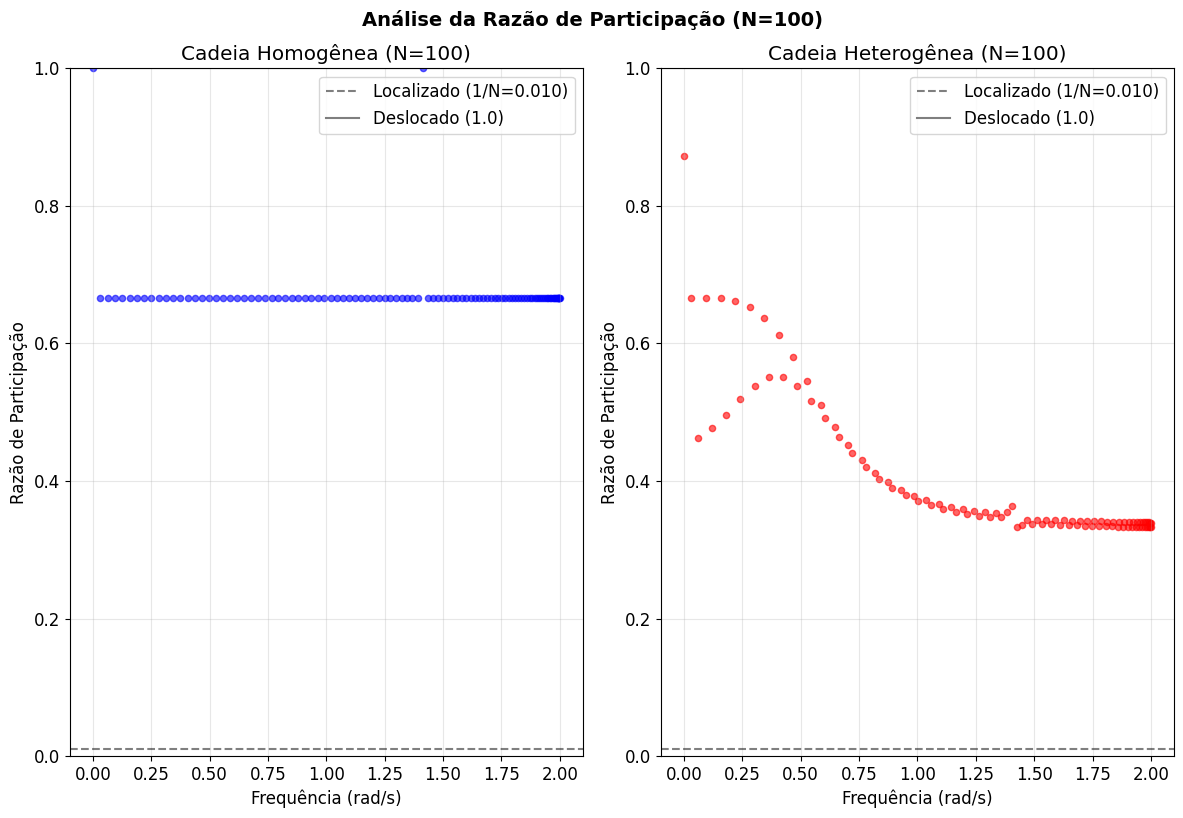


Estatísticas da razão de participação para N=100:
  Cadeia Homogênea:
    PR Médio: 0.6733
    PR Std: 0.0467
    PR Min: 0.6667
  Cadeia Heterogênea:
    PR Médio: 0.4029
    PR Std: 0.1054
    PR Min: 0.3330
  Modos Localizados (PR < 0.5):
    Homogêneo: 0 (0.0%)
    Heterogêneo: 83 (83.0%)


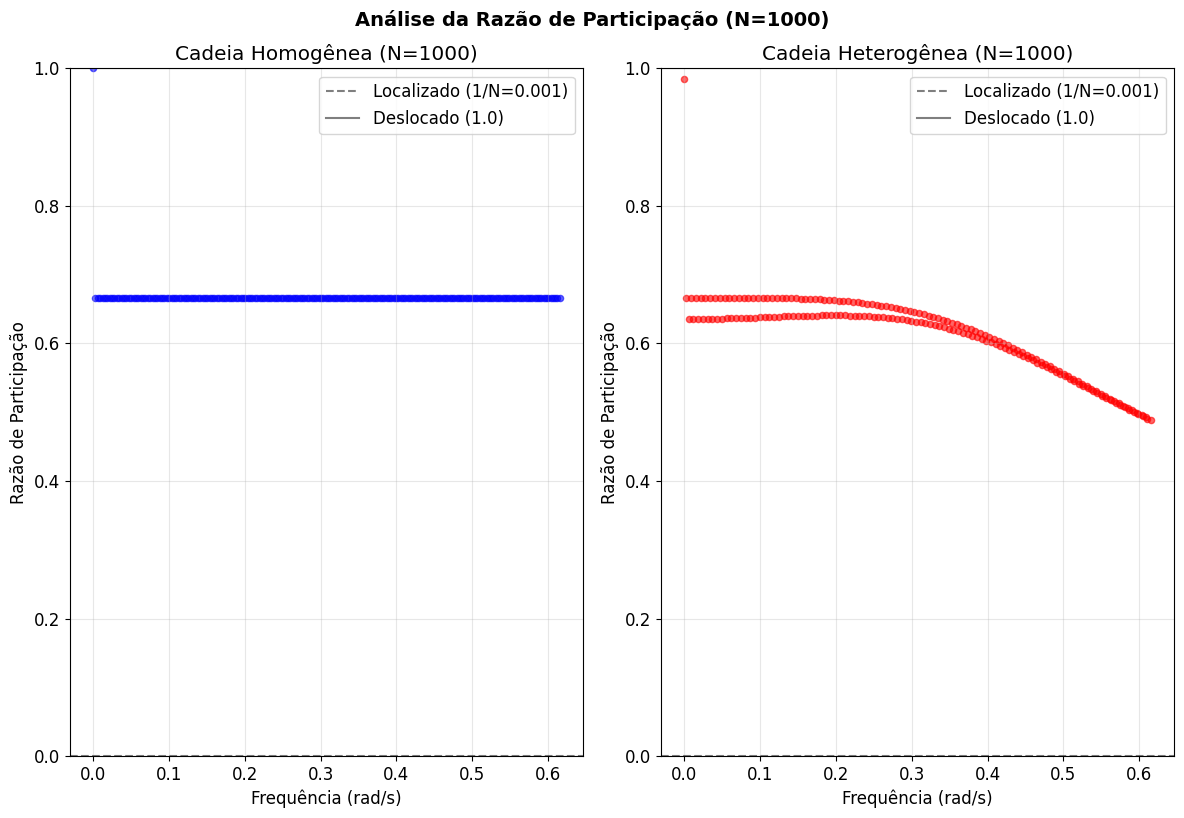


Estatísticas da razão de participação para N=1000:
  Cadeia Homogênea:
    PR Médio: 0.6683
    PR Std: 0.0235
    PR Min: 0.6667
  Cadeia Heterogênea:
    PR Médio: 0.6120
    PR Std: 0.0581
    PR Min: 0.4895
  Modos Localizados (PR < 0.5):
    Homogêneo: 0 (0.0%)
    Heterogêneo: 7 (3.5%)


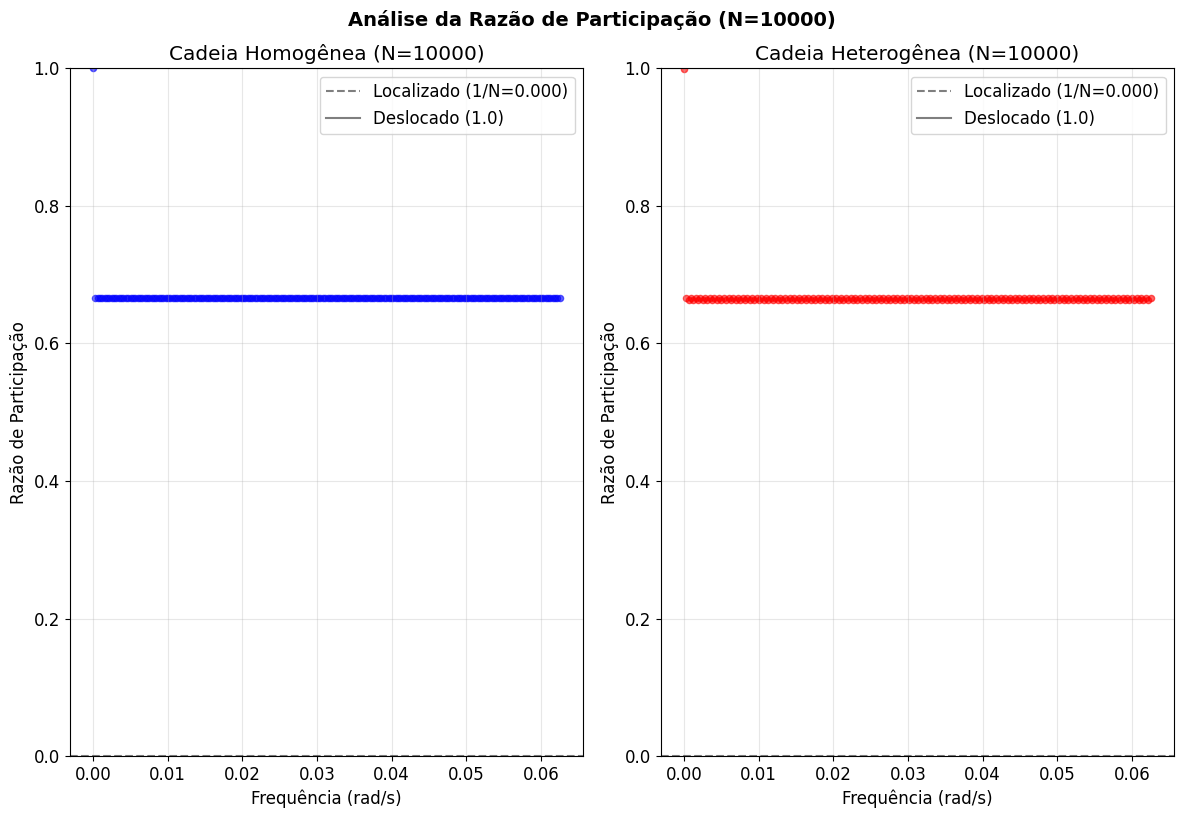


Estatísticas da razão de participação para N=10000:
  Cadeia Homogênea:
    PR Médio: 0.6683
    PR Std: 0.0235
    PR Min: 0.6667
  Cadeia Heterogênea:
    PR Médio: 0.6667
    PR Std: 0.0236
    PR Min: 0.6634
  Modos Localizados (PR < 0.5):
    Homogêneo: 0 (0.0%)
    Heterogêneo: 0 (0.0%)


In [78]:
for N in len_cadeias:
        plot_participation_ratio(results, N)

In [79]:
def generate_summary_table(results: Dict, len_cadeias: List[int]):
    print(f"\n{'='*80}")
    print(f"RESUMO")
    print(f"{'='*80}")
    
    print(f"\nParâmetros do Sistema:")
    print(f"  Massa Padrão (m): {m} kg")
    print(f"  Massa Defeito (m2): {m2} kg")
    print(f"  Constante da Mola (k): {k} N/m")
    print(f"  Razão das Massas (m2/m): {m2/m:.1f}")
    
    print(f"\n{'Comprimento da Cadeia':<12} {'Config':<12} {'# Modos':<8} {'Freq Min':<10} {'Freq Max':<10} {'Freq Média':<10}")
    print(f"{'-'*70}")
    
    for N in len_cadeias:
        if N not in results:
            continue
            
        for config_name in ['homogeneous', 'defective']:
            freq = results[N][config_name]['frequencies']
            print(f"{N:<12} {config_name:<12} {len(freq):<8} {freq.min():<10.4f} "
                  f"{freq.max():<10.4f} {freq.mean():<10.4f}")
    
    print(f"\n{'='*80}")
    print(f"OBSERVAÇÕES PRINCIPAIS:")
    print(f"{'='*80}")

    print(f"\n1. CRESCIMENTO DA FAIXA DE FREQUÊNCIAS:")
    for N in len_cadeias:
        if N not in results:
            continue
        homo_freq = results[N]['homogeneous']['frequencies']
        defect_freq = results[N]['defective']['frequencies']
        
        homo_range = homo_freq.max() - homo_freq.min()
        defect_range = defect_freq.max() - defect_freq.min()
        
        print(f"   N={N:5d}: Faixa Homogênea = {homo_range:.4f}, "
              f"Faixa Heterogênea = {defect_range:.4f}")
    
    print(f"\n2. EFEITOS DO DEFEITO NOS EXTREMOS DA FREQUÊNCIA:")
    for N in len_cadeias:
        if N not in results:
            continue
        homo_freq = results[N]['homogeneous']['frequencies']
        defect_freq = results[N]['defective']['frequencies']
        
        max_shift = defect_freq.max() - homo_freq.max()
        min_shift = defect_freq.min() - homo_freq.min()
        
        print(f"   N={N:5d}: Deslocamento max da freq = {max_shift:+.4f}, "
              f"Deslocamento min da freq = {min_shift:+.4f}")

In [80]:
generate_summary_table(results, len_cadeias)


RESUMO

Parâmetros do Sistema:
  Massa Padrão (m): 1.0 kg
  Massa Defeito (m2): 5.0 kg
  Constante da Mola (k): 1.0 N/m
  Razão das Massas (m2/m): 5.0

Comprimento da Cadeia Config       # Modos  Freq Min   Freq Max   Freq Média
----------------------------------------------------------------------
100          homogeneous  100      0.0000     1.9998     1.2632    
100          defective    100      0.0000     1.9990     1.2566    
1000         homogeneous  200      0.0000     0.6150     0.3100    
1000         defective    200      0.0000     0.6148     0.3095    
10000        homogeneous  200      0.0000     0.0625     0.0313    
10000        defective    200      0.0000     0.0625     0.0313    

OBSERVAÇÕES PRINCIPAIS:

1. CRESCIMENTO DA FAIXA DE FREQUÊNCIAS:
   N=  100: Faixa Homogênea = 1.9998, Faixa Heterogênea = 1.9990
   N= 1000: Faixa Homogênea = 0.6150, Faixa Heterogênea = 0.6148
   N=10000: Faixa Homogênea = 0.0625, Faixa Heterogênea = 0.0625

2. EFEITOS DO DEFEITO NOS EXT